# Flag missing values
One strategy for accounting for missing values is to simply ignore them. This is usually not a good idea because you often have little insight into how the missing data influenced the results.

# Complete case analysis
The opposite strategy from tracking all your missing values is to delete either rows (observations) or columns (features), from your training data. In the case of deleting rows, this is called complete case analysis, and is quite common.

In [49]:
import pandas as pd
import numpy as np
from numpy import nan
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame({'name': ['apple', 'banana', 'orange'],
                  'price': [1.95, 3.00, nan], 'inventory': [nan, 12, 23]})

print(df)

     name  price  inventory
0   apple   1.95        NaN
1  banana   3.00       12.0
2  orange    NaN       23.0


In [50]:
#The default behavior of the .dropna method is to return a new DataFrame containing only the complete rows.
print(df.dropna())

     name  price  inventory
1  banana    3.0       12.0


In [51]:
print(df.dropna(axis='columns'))


     name
0   apple
1  banana
2  orange


# Categories of missing data
### Missing complete at random or MCAR:
 * Missing cases are, on average, identical to non-missing cases, with respect to the feature matrix.
   Complelte case analysos will reduce the power of the analysis, but will not assect bias
### Missing at random or MAR:
 * When data are MAR the missing data often have some dependence on measured values, and models can be used to help impute what the likely data would be. For example, in a Major League Baseball (MLB) survey, there might be a disproportionate number of male respondents completing all of the questions as compared to females, since males comprise most of the MLB's viewership.
### Missing not at random or MNAR:
 * In this case the missing data depend on unmeasured or unknown variables. There is no information available to account for the missingness.
Of these three categories, the best case scenario is that the data are MCAR. It should be noted that imputing values under the other two types of missingness can result in an increase in bias. Many strategies have been proposed for the management and replacement of missing values—a process known as imputation. In this unit we will illustrate the method of simple imputation, as well as two more sophisticated strategies: Multiple imputation and Bayesian imputation. In the case study that follows we will also exemplify the iterative process for deciding which strategy is best.
 
 

In [52]:
# Simple imputation
from sklearn.impute import SimpleImputer

features = ['price', 'inventory']
imp = SimpleImputer()

# Use .values attribute bc sklearn works with arrays rather than DataFrames
imp.fit(df[features].values)

print(imp.transform(df[features].values))

[[ 1.95  17.5  ]
 [ 3.    12.   ]
 [ 2.475 23.   ]]


In [53]:
df[features].values

array([[ 1.95,   nan],
       [ 3.  , 12.  ],
       [  nan, 23.  ]])

# The data 
Lets say that you were starting with AVAIL data, but some missing values are not a regular part og this dataset -- specifically we are missing the is_subscriber values for a number of customers

In [103]:
df = pd.read_csv(r'aavail-target.csv ')
df.isnull().sum()
# df.head()

customer_id        0
country_name       0
age                0
customer_name      0
is_subscriber      0
subscriber_type    0
num_streams        0
dtype: int64

In [96]:
df['is_subscriber'].apply(lambda x: 1 if x == True else 0)

0      1
1      0
2      0
3      1
4      1
      ..
995    0
996    1
997    1
998    1
999    1
Name: is_subscriber, Length: 1000, dtype: int64

In [56]:
df['is_subscriber'] = df['is_subscriber'].apply(lambda x: 1 if x == True else 0)

In [100]:
df.isnull().sum()

customer_id        0
country_name       0
age                0
customer_name      0
is_subscriber      0
subscriber_type    0
num_streams        0
dtype: int64

In [57]:
# df
from sklearn.preprocessing import OneHotEncoder
one1 = OneHotEncoder()
column = df['subscriber_type'].values.reshape(-1,1)
one1.fit(column)
labels1 = one1.categories_[0].tolist()
X1 = one1.transform(column).toarray()

# one hot encode the country 
one2 = OneHotEncoder()
column = df['country_name'].values.reshape(-1,1)
one2.fit(column)
labels2 = one2.categories_[0].tolist()
X2 = one2.transform(column).toarray()

# concat all of the data
labels = ['is_subscriber', 'age', 'num_streams']
X = df.loc[:, labels].to_numpy()
labels = labels + labels1 + labels2
X = np.hstack([X, X1, X2])
df1 = pd.DataFrame({label: X[:, i] for i, label in enumerate(labels)})
df1.head()

is_subscriber   age  num_streams  aavail_basic  aavail_premium  \
0            1.0  21.0         23.0           0.0             1.0   
1            0.0  31.0         12.0           0.0             0.0   
2            0.0  22.0         22.0           0.0             1.0   
3            1.0  21.0         19.0           1.0             0.0   
4            1.0  22.0         23.0           0.0             1.0   

   aavail_unlimited  singapore  united_states  
0               0.0        0.0            1.0  
1               1.0        1.0            0.0  
2               0.0        0.0            1.0  
3               0.0        0.0            1.0  
4               0.0        1.0            0.0

In [58]:
print(X.shape)
np.random.seed(0)
num_nulls = 50
null_rows = np.random.choice(X.shape[0], size=num_nulls, replace = False)
null_col = [0]*num_nulls
known_missing = X[null_rows, null_col].copy()
X[null_rows, null_col] = np.nan

print(np.isnan(X).sum(axis=0))

(1000, 8)
[50  0  0  0  0  0  0  0]


In [105]:
X

array([[ 1., 21., 23., ...,  0.,  0.,  1.],
       [nan, 31., 12., ...,  1.,  1.,  0.],
       [ 0., 22., 22., ...,  0.,  0.,  1.],
       ...,
       [ 1., 25., 17., ...,  1.,  0.,  1.],
       [ 1., 40., 16., ...,  1.,  0.,  1.],
       [ 1., 21., 18., ...,  1.,  0.,  1.]])

In [59]:
def make_corr_plot(df, columns):
    '''
    make a pairwise correlation plot
    '''
    
    # Compute the correlation matrix
    corr = df[columns].corr()
    # Generate a mask for upper triangle 
    mask = np.zeros_like(corr, dtype = np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 7), dpi=150, facecolor='white')
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    # Draw the heatmap with the mask and correct aspect ratio 
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
               square=True, linewidths=.5, cbar_kws={'shrink': .5})

In [93]:
df1.shape

(1000, 8)

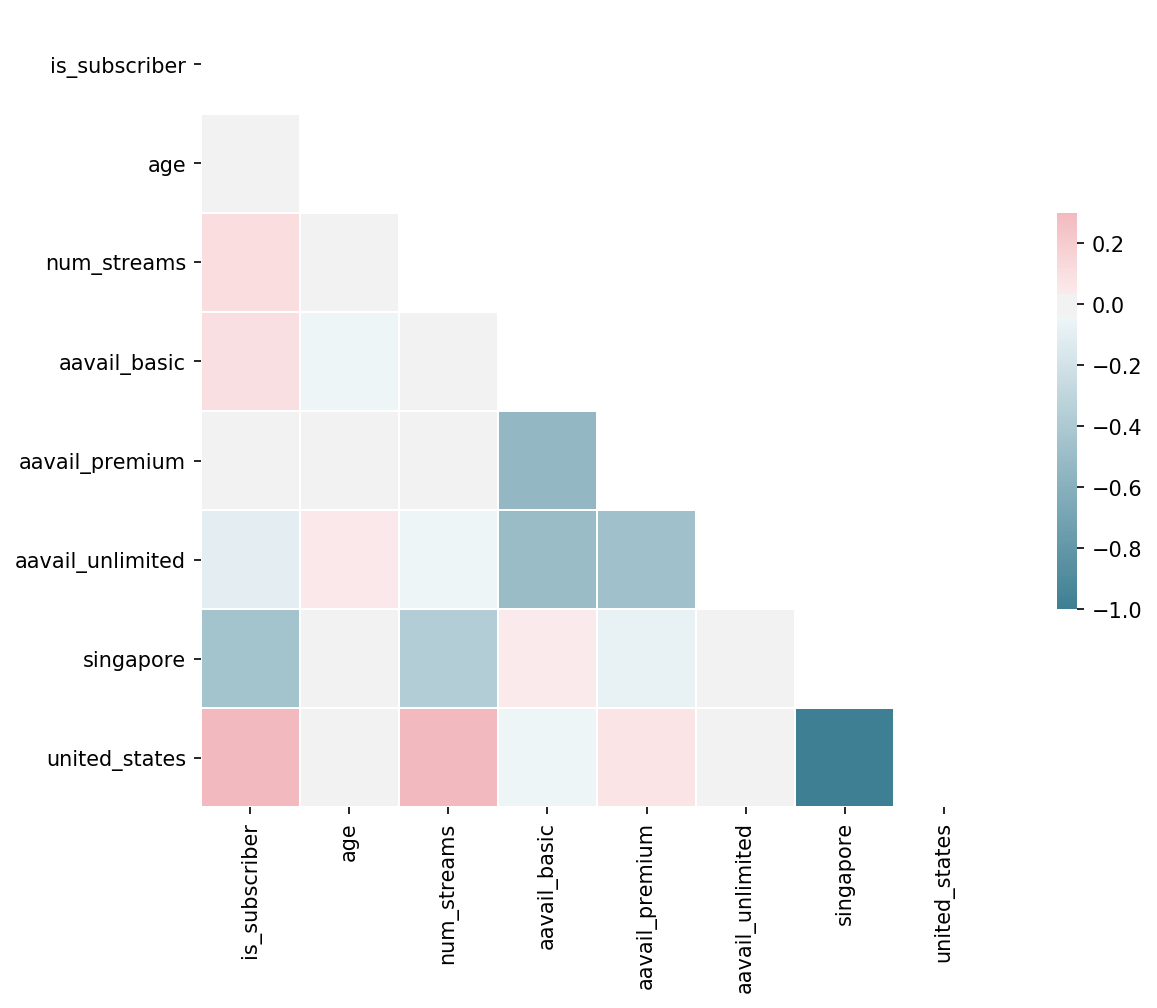

In [61]:
make_corr_plot(df1, labels)

In [104]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

## variables
impute_col = 0
C = 0.01

# identify the values that can be used as features
y_impute = X[:, impute_col].copy()
X_impute = X[:, np.setdiff1d(np.arange(X.shape[1]), impute_col)].copy()
missing = np.isnan(y_impute)

# scale using sklearn 
scaler = preprocessing.StandardScaler().fit(X_impute)
X_impute = scaler.transform(X_impute)


mod1 = LogisticRegression(C = C)
mod1.fit(X_impute[~missing], y_impute[~missing])
print(X_impute[missing].shape)
predicted_missing = mod1.predict(X_impute[missing])
print(classification_report(known_missing, predicted_missing, target_names=['inactive', 'subscriber']))

X1 = X.copy()
X1[missing, impute_col] = predicted_missing

(50, 7)
              precision    recall  f1-score   support

    inactive       0.36      0.27      0.31        15
  subscriber       0.72      0.80      0.76        35

    accuracy                           0.64        50
   macro avg       0.54      0.53      0.53        50
weighted avg       0.61      0.64      0.62        50



In [86]:
# np.setdiff1d(np.arange(X.shape[1]), impute_col)

missing.shape, X_impute[~missing].shape

((1000,), (950, 7))

In [76]:
missing

array([False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [71]:
impute_col

0